# Quant GAN
## Tensor Flow Version
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [ ]:
#%%capture
import os, sys
file_name = 'SP500_daily'  # 'ShanghaiSE_daily' or 'SP500_daily'
colab = 'COLAB_GPU' in os.environ
file_path = f'./data/{file_name}.csv'
generator_path = f'./trained/'
if colab:
	!pip install tensorflow-addons
	file_path = f'/content/temporalCN/data/{file_name}.csv'
	generator_path = f'/content/temporalCN/trained/'
	username = "JamesSullivan"
	repository = "temporalCN"
	!git clone https://github.com/{username}/{repository}.git
	sys.path.append('/content/temporalCN/')


     |████████████████████████████████| 1.1 MB 7.4 MB/s 
Cloning into 'temporalCN'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 66 (delta 20), reused 62 (delta 16), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocess.acf import *
from preprocess.gaussianize import *

from tensorflow.random import normal
from tensorflow.keras.models import load_model
from google.colab import files
from model.tf_gan import GAN
from model.tf_tcn import *

input_dim: [1, None, 3]
kernel_size: 1  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 2, fixed_filters: 80 cropping: 2
kernel_size: 2  dilation: 4, fixed_filters: 80 cropping: 6
kernel_size: 2  dilation: 8, fixed_filters: 80 cropping: 14
kernel_size: 2  dilation: 16, fixed_filters: 80 cropping: 30
kernel_size: 2  dilation: 32, fixed_filters: 80 cropping: 62
input_dim: [1, 127, 1]
kernel_size: 1  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 2, fixed_filters: 80 cropping: 2
kernel_size: 2  dilation: 4, fixed_filters: 80 cropping: 6
kernel_size: 2  dilation: 8, fixed_filters: 80 cropping: 14
kernel_size: 2  dilation: 16, fixed_filters: 80 cropping: 30
kernel_size: 2  dilation: 32, fixed_filters: 80 cropping: 62


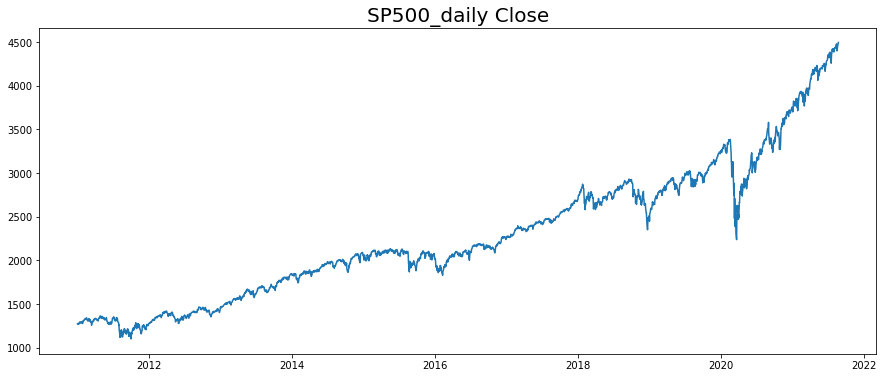

In [ ]:
def dateparse(d):
    return pd.Timestamp(d)

data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['CLOSE']
fig = plt.figure(figsize=(15,6))
plt.title(f'{file_name} Close', fontsize=20)
plt.plot(data['datetime'], data['CLOSE'] )
plt.show()
# confirm data loaded

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [ ]:
returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
log_returns_rolled = rolling_window(log_returns_preprocessed, receptive_field_size)
data_size = log_returns.shape[0]
print(data_size)

2679


## Train model
 For more details see [tf_model.ipynb](./tf_model.ipynb)

In [ ]:
train = True

if train:
  gan = GAN(discriminator, generator, 2 * receptive_field_size - 1, lr_d=1e-4, lr_g=3e-5)
  gan.acf_real = acf(log_returns_preprocessed, 250)
  gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
  gan.le_real = acf(log_returns_preprocessed, 250, le=True)
  gan.fixed_noise = normal([128, 1, data_size + receptive_field_size - 1, 3])
  data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
  batch_size = 64
  n_batches = 3000
  gan.train(data, batch_size, n_batches)
  generator.save(f'trained_generator_{file_name}')
  !zip -r trained_generator_{file_name}.zip trained_generator_{file_name}/
  files.download(f'trained_generator_{file_name}.zip')
else:
  print(f"Loading: {generator_path}trained_generator_{file_name}")
  generator = load_model(f"{generator_path}trained_generator_{file_name}")
  # generator = load_model(f"/temporalCN/trained/trained_generator_ShanghaiSE_daily")


 499/3000 [===>..........................] - ETA: 5:11
acf: 0.3785, acf_abs: 1.4165, le: 0.3863
 999/3000 [========>.....................] - ETA: 4:23
acf: 0.3432, acf_abs: 1.3289, le: 0.3723
1499/3000 [=============>................] - ETA: 3:20
acf: 0.3374, acf_abs: 1.2803, le: 0.3753
1999/3000 [==================>...........] - ETA: 2:14
acf: 0.3345, acf_abs: 1.2252, le: 0.3281
2499/3000 [=======================>......] - ETA: 1:07
acf: 0.3336, acf_abs: 1.1879, le: 0.3129
2999/3000 [============================>.] - ETA: 0s
acf: 0.3331, acf_abs: 1.2562, le: 0.3590
3000/3000 [==============================] - 457s 138ms/step


INFO:tensorflow:Assets written to: trained_generator_SP500_daily/assets


INFO:tensorflow:Assets written to: trained_generator_SP500_daily/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


  adding: trained_generator_SP500_daily/ (stored 0%)
  adding: trained_generator_SP500_daily/assets/ (stored 0%)
  adding: trained_generator_SP500_daily/saved_model.pb (deflated 91%)
  adding: trained_generator_SP500_daily/variables/ (stored 0%)
  adding: trained_generator_SP500_daily/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: trained_generator_SP500_daily/variables/variables.index (deflated 79%)
  adding: trained_generator_SP500_daily/keras_metadata.pb (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generate

In [ ]:
noise = normal([512, 1, len(log_returns_preprocessed) + receptive_field_size - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

500

## Results and visualizing stylized facts

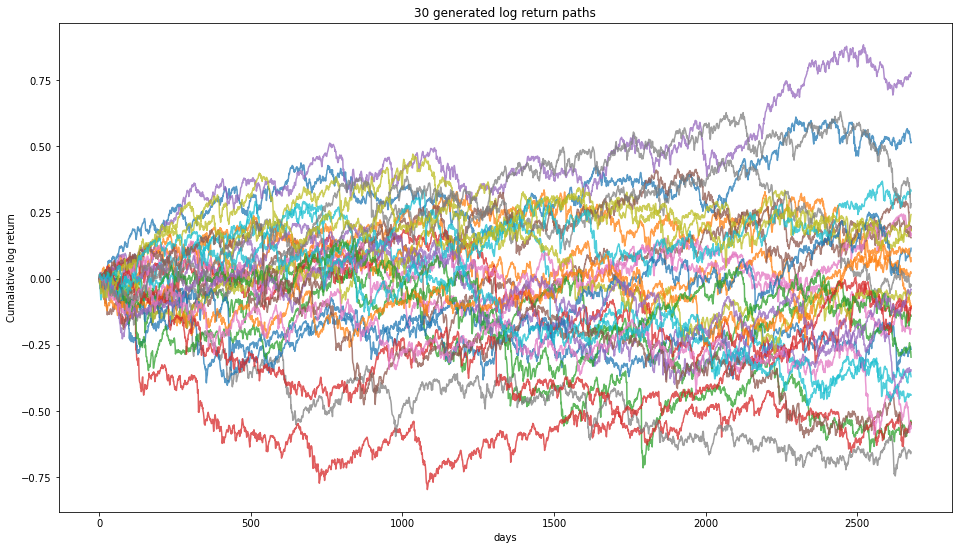

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

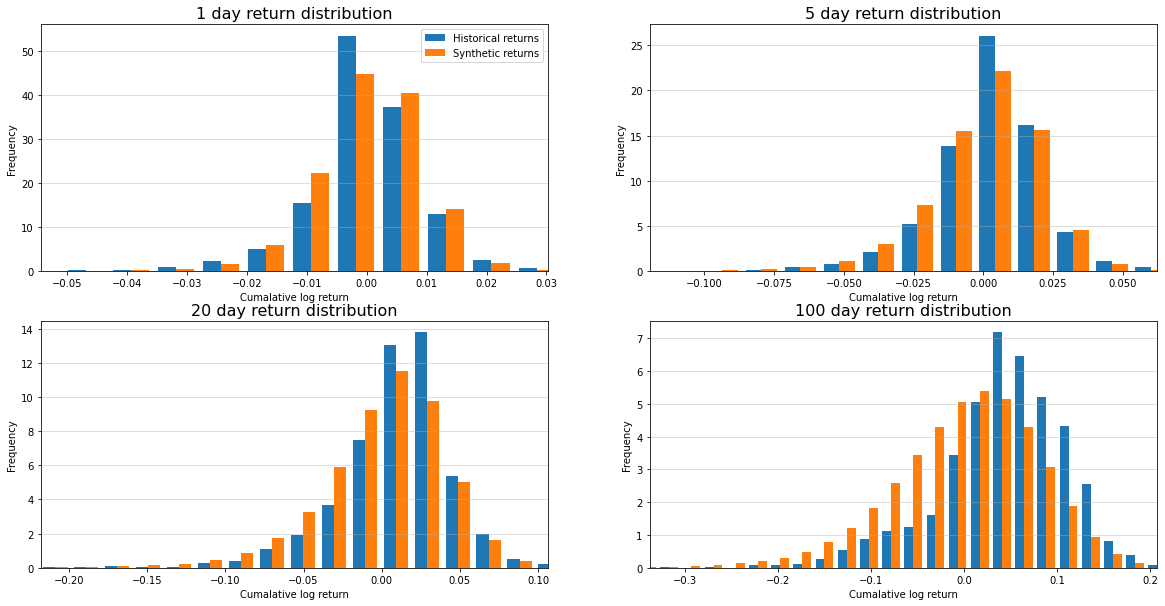

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

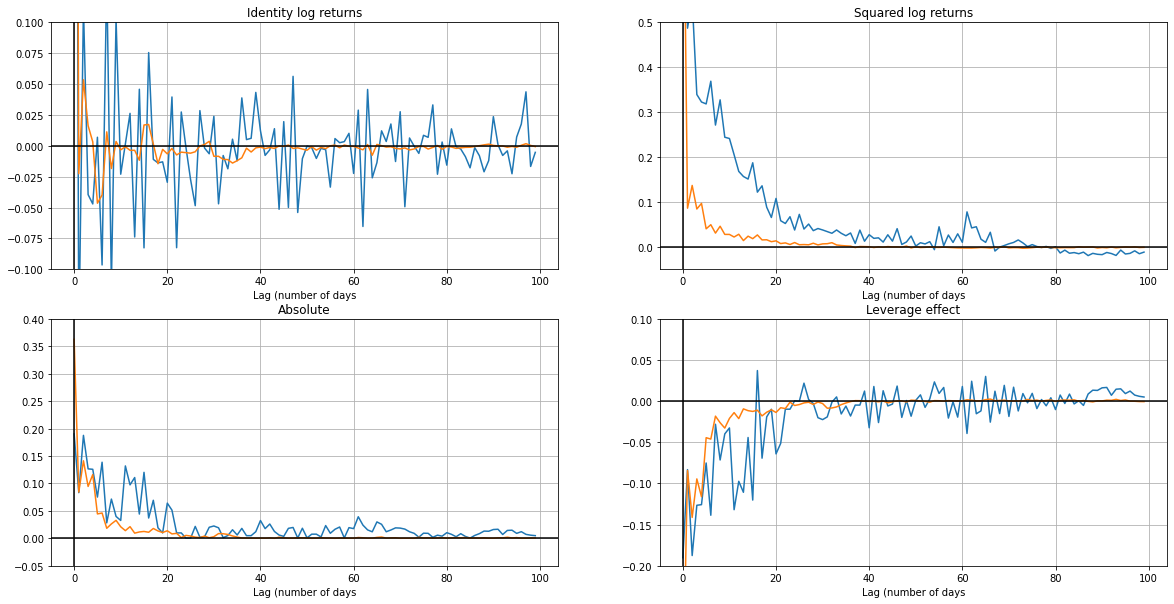

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')